<a href="https://colab.research.google.com/github/soltani-bochra/Data-Science-and-Machine-Learning/blob/main/nlp_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment - Sentiment Analysis of Movie Reviews

![](https://i.imgur.com/6Wfmf2S.png)

> **Problem Statement**: Apply the TF-IDF technique to train ML models for sentiment analysis using data from the "[Sentiment Analysis on Movie Reviews](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews)" Kaggle competition.


Outline:

1. Download and Explore Dataset
2. Implement the TF-IDF Technique
3. Train baseline model & submit to Kaggle
4. Train & finetune different ML models
3. Document & submit your notebook


Dataset: https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews


## Download and Explore the Data

Outline:

1. Download Dataset from Kaggle
2. Explore and visualize data

### Download Dataset from Kaggle

- Read the "Description", "Evaluation" and "Data" sections on the Kaggle competition page carefully
- Make sure to download the `kaggle.json` file from your [Kaggle account](https://kaggle.com/me/account) and upload it on Colab

In [1]:
import os

In [2]:
!pwd

/content


In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [4]:
!kaggle competitions download -c sentiment-analysis-on-movie-reviews

  0% 0.00/1.90M [00:00<?, ?B/s]
100% 1.90M/1.90M [00:00<00:00, 152MB/s]


In [5]:
!unzip sentiment-analysis-on-movie-reviews.zip -d data

Archive:  sentiment-analysis-on-movie-reviews.zip
  inflating: data/sampleSubmission.csv  
  inflating: data/test.tsv.zip       
  inflating: data/train.tsv.zip      


In [7]:
train_fname = 'data/train.tsv.zip'
test_fname = 'data/test.tsv.zip'
sub_fname = 'data/sampleSubmission.csv'

### Explore and Visualize Data

* Load the train, test, and submission files using Pandas
* Explore rows, columns, sample values etc.
* Visualize distribution of target columns

In [8]:
import pandas as pd

In [9]:
raw_df = pd.read_csv(train_fname, sep='\t')

In [10]:
raw_df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [11]:
raw_df.Phrase.sample(10).values

array(['hard as this may be to believe , Here on Earth , a surprisingly similar teen drama , was a better film .',
       'is better than any summer blockbuster',
       'an alternate version , but as the ultimate exercise in viewing deleted scenes',
       'animation back 30 years ,',
       'went nihilistic that it summons more spirit and bite than your average formulaic romantic quadrangle',
       'have relied too much on convention in creating the characters who surround Frankie',
       'is a movie that makes it possible for the viewer to doze off for a few minutes or make several runs to the concession stand and\\/or restroom and not feel as if he or she has missed anything',
       'sees working women -- or at least this working woman -- for whom she shows little understanding',
       "I 'm not sure which half of Dragonfly is worse : The part where nothing 's happening , or the part where something 's happening",
       'considerable aplomb'], dtype=object)

In [12]:
test_df = pd.read_csv(test_fname, sep='\t')

In [13]:
test_df

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


In [14]:
sub_df = pd.read_csv(sub_fname)

In [15]:
sub_df

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
...,...,...
66287,222348,2
66288,222349,2
66289,222350,2
66290,222351,2


<Axes: >

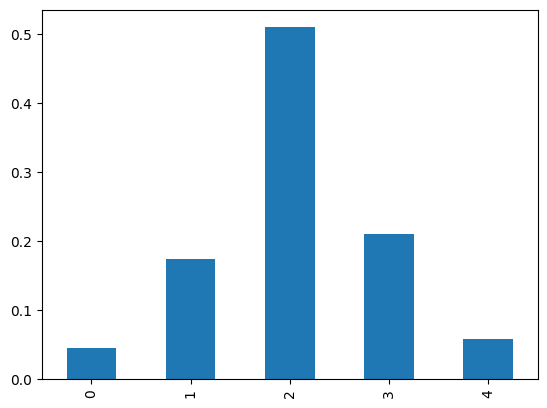

In [16]:
raw_df.Sentiment.value_counts(normalize=True).sort_index().plot(kind='bar')

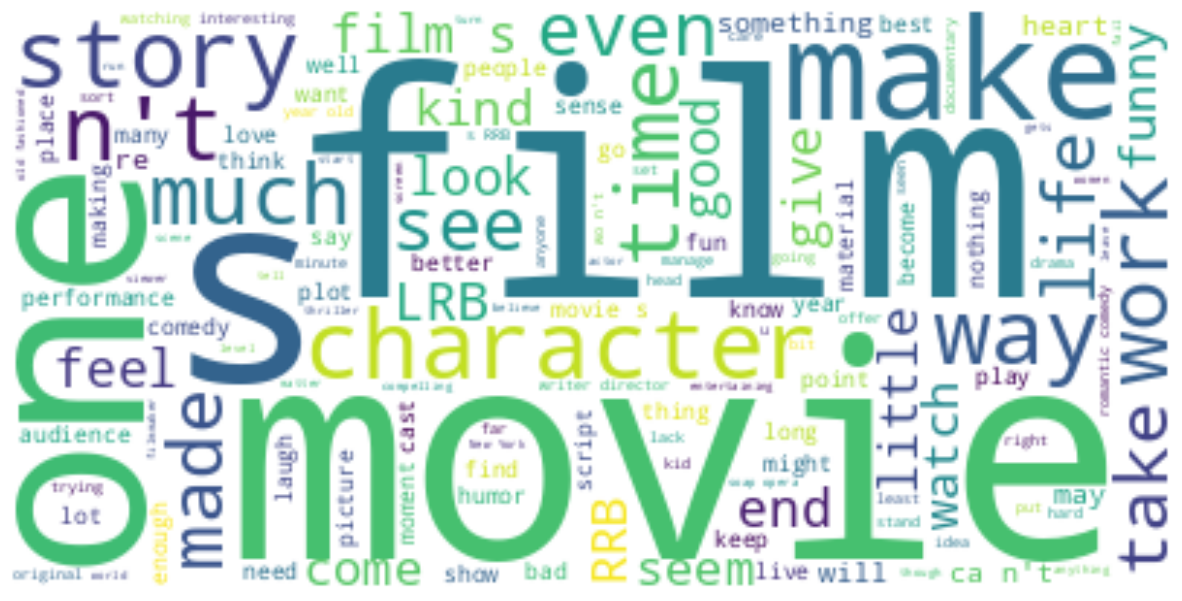

In [76]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
text = " ".join(i for i in raw_df.Phrase)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Summarizing the observations and knowledge gained from the dataset:

* The distribution of labels follows a Normal distribution, forming an ideal Bell Curve. Neutral Sentiment is the most prevalent in the dataset, positioned in the middle with the highest count, while Negative and Positive Sentiment labels are found to the left and right, respectively.

* Upon visualizing the most frequently occurring words in the Phrase column of the dataset, it becomes evident that the primary focus is on elements such as film, movie, character, and story.

* The Training Subset comprises 156,060 rows of data, with the Test Subset representing almost 43% of the size of the training subset.

## Implement TF-IDF Technique

![](https://i.imgur.com/5VbUPup.png)

Outline:

1. Learn the vocabulary using `TfidfVectorizer`
3. Transform training and test data

#### Learn Vocabulary using `TfidfVectorizer `

* Create custom tokenizer with stemming
* Create a list of stop words
* Configure and create `TfidfVectorizer `
* Learn vocubulary from training set
* View sample entries from vocabulary

In [17]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

In [18]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [19]:
stemmer = SnowballStemmer(language='english')

In [20]:
def tokenize(text):
    return [stemmer.stem(token) for token in word_tokenize(text) if token.isalpha()]

In [21]:
tokenize('Is this (the) really life, 12 or is it; fantasy?')

['is', 'this', 'the', 'realli', 'life', 'or', 'is', 'it', 'fantasi']

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
from nltk.corpus import stopwords

In [24]:
english_stopwords = stopwords.words('english')

In [25]:
", ".join(english_stopwords[:115])

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some"

In [26]:
selected_stopwords = english_stopwords[:115]

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
vectorizer = TfidfVectorizer(tokenizer=tokenize,
                             stop_words=selected_stopwords,
                             ngram_range=(1, 2),
                             max_features=2000)

In [29]:
vectorizer.fit(raw_df.Phrase)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'ourselv', 'themselv', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


TfidfVectorizer(max_features=2000, ngram_range=(1, 2),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x7a75242236d0>)

In [30]:
len(vectorizer.vocabulary_)

2000

In [31]:
vectorizer.get_feature_names_out()[:200]

array(['abandon', 'abil', 'abl', 'abov', 'absolut', 'absorb', 'abstract',
       'absurd', 'abus', 'accent', 'accept', 'access', 'accomplish',
       'accur', 'ach', 'achiev', 'across', 'act', 'action', 'action film',
       'action movi', 'action sequenc', 'actor', 'actress', 'actual',
       'ad', 'adam', 'adam sandler', 'adapt', 'add', 'addit', 'adequ',
       'admir', 'admit', 'adolesc', 'adult', 'adventur', 'affair',
       'affect', 'afraid', 'age', 'ago', 'ahead', 'aim', 'aimless', 'air',
       'alien', 'aliv', 'allen', 'allow', 'almost', 'alon', 'along',
       'alreadi', 'also', 'altern', 'although', 'alway', 'amateurish',
       'amaz', 'ambigu', 'ambit', 'ambiti', 'america', 'american',
       'among', 'amount', 'amus', 'analyz', 'angel', 'angst', 'ani',
       'anim', 'ann', 'annoy', 'anoth', 'answer', 'anyon', 'anyth',
       'apart', 'appar', 'appeal', 'appear', 'appli', 'appreci',
       'approach', 'appropri', 'area', 'argu', 'argument', 'around',
       'arriv', 'art'

### Transform Training & Test Data

* Transform phrases from training set
* Transform phrases from test set
* Look at some example values

In [32]:
raw_df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [33]:
inputs = vectorizer.transform(raw_df.Phrase)

In [34]:
inputs.shape

(156060, 2000)

In [35]:
inputs.toarray()[0][:100]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.27620188,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.33022325, 0.29314979, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [36]:
test_df

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


In [37]:
test_inputs = vectorizer.transform(test_df.Phrase)

In [38]:
test_inputs.shape

(66292, 2000)

## Train Baseline Model & Submit to Kaggle

1. Split training and validation sets
2. Train logistic regression model
3. Study predictions on sample phrases
4. Make predictions and submit to Kaggle




### Split Training and Validation Sets

Tip: Don't use a random sample for validation set (why?)

In [41]:
raw_df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [42]:
TRAIN_SIZE = 110_000

In [43]:
train_inputs = inputs[:TRAIN_SIZE]
train_targets = raw_df.Sentiment[:TRAIN_SIZE]

In [44]:
train_inputs.shape, train_targets.shape

((110000, 2000), (110000,))

In [45]:
val_inputs = inputs[TRAIN_SIZE:]
val_targets = raw_df.Sentiment[TRAIN_SIZE:]

In [46]:
val_inputs.shape, val_targets.shape

((46060, 2000), (46060,))

### Train Logistic Regression Model



In [47]:
from sklearn.linear_model import LogisticRegression

In [48]:
model = LogisticRegression()

In [49]:
model.fit(train_inputs, train_targets)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [50]:
train_preds = model.predict(train_inputs)

In [51]:
train_targets

0         1
1         2
2         2
3         2
4         2
         ..
109995    1
109996    0
109997    1
109998    0
109999    2
Name: Sentiment, Length: 110000, dtype: int64

In [52]:
train_preds

array([3, 2, 2, ..., 0, 0, 2])

In [53]:
from sklearn.metrics import accuracy_score

In [54]:
accuracy_score(train_targets, train_preds)

0.6381818181818182

In [55]:
val_preds = model.predict(val_inputs)

In [56]:
accuracy_score(val_targets, val_preds)

0.5795049934867564

### Study Predictions on Sample Inputs

In [57]:
small_df = raw_df.sample(20)

In [58]:
small_df

,PhraseId,SentenceId,Phrase,Sentiment
17340,17341,752,Minac,2
33619,33620,1577,all the mounting tension,2
13436,13437,578,"because of the universal themes , earnest perf...",3
103245,103246,5444,something really good,4
37602,37603,1787,"those crazy , mixed-up films that does n't kno...",2
61942,61943,3132,be one of them,2
149107,149108,8113,at least three dull plots,1
88048,88049,4573,", Interview with the Assassin draws its consid...",3
40679,40680,1949,And it is .,3
74991,74992,3846,will be hard pressed to succumb to the call of...,2


In [59]:
small_inputs = vectorizer.transform(small_df.Phrase)

In [60]:
small_inputs.shape

(20, 2000)

In [61]:
small_preds = model.predict(small_inputs)

In [62]:
small_preds

array([2, 2, 3, 3, 2, 2, 0, 3, 2, 1, 2, 2, 3, 2, 2, 2, 3, 2, 2, 0])

### Make Predictions & Submit to Kaggle

1. Make predictions on Test Dataset
2. Generate & submit CSV on Kaggle
3. Add screenshot of your score



In [63]:
test_df

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


In [64]:
test_inputs

<66292x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 181514 stored elements in Compressed Sparse Row format>

In [65]:
test_preds = model.predict(test_inputs)

In [66]:
test_preds

array([3, 3, 2, ..., 2, 2, 1])

In [67]:
sub_df

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
...,...,...
66287,222348,2
66288,222349,2
66289,222350,2
66290,222351,2


In [68]:
sub_df.Sentiment = test_preds

In [69]:
sub_df.to_csv('submission.csv', index=None)

In [70]:
!head submission.csv

PhraseId,Sentiment
156061,3
156062,3
156063,2
156064,3
156065,2
156066,3
156067,3
156068,2
156069,3


## Train & Finetune Different ML Models

Train & finetune at least 2 other types of models

Models to try:
- Decision Trees
- Random Forests
- Gradient Boosting
- Naive Bayes
- SVM

Optional:
* Use PCA for dimensionality reduction
* Compare classification vs regression models


Tips:

- If using a regression model, make sure to round predictions to integer and clip to the range `[1,5]`
- Track your progress in a copy of [this experiment tracking spreadsheet](https://docs.google.com/spreadsheets/d/1X-tifxAOAYeIA2J32hBGP5B0MPnZy_o-zOz1NbS-1Ig/edit?usp=sharing)


Model 1 - Naive Bayes

In [71]:
from sklearn.naive_bayes import MultinomialNB

In [72]:
model1 = MultinomialNB(class_prior=(0.05, 0.2, .5, 0.2, .05))

In [73]:
model1.fit(train_inputs, train_targets)

MultinomialNB(class_prior=(0.05, 0.2, 0.5, 0.2, 0.05))

In [74]:
accuracy_score(train_targets, model1.predict(train_inputs))

0.5881636363636363

In [75]:
accuracy_score(val_targets, model1.predict(val_inputs))

0.5453755970473295

Model 2 - Random Forest


In [77]:
from sklearn.ensemble import RandomForestClassifier

In [82]:
model_2.fit(train_inputs, train_targets)

RandomForestClassifier(max_depth=5, max_features=500, n_estimators=1000,
                       random_state=0)

In [83]:
accuracy_score(train_targets, model_2.predict(train_inputs))

0.5234454545454545

In [84]:
accuracy_score(val_targets, model_2.predict(val_inputs))

0.49991315675206255

### Model 3

Best Model:

Logistic Regression with followering hyperparameters: (solver='newton-cg', random_state=0, max_iter=2000)

## Submission and Future Work


How to make a submission:

- Add documentation and explanations
- Clean up any stray code/comments
- Include a screenshot of your best score
- Make a submission on the assignment page
- Review evaluation criteria carefully


Future work:
- Try more machine learning models
- Try configuring CountVectorizer differently
- Try approaches other than bag of words
